# Vehicle time response reliability on vehicle automation: Evidence from experimental driving modes in platooning conditions

## Finding Response Time 

The following procedures consist in importing the available datasets and compute the response time of vehicles in a platoon mode. For that the methodology is as follows: 

1. Consider a profile of speed for a leader `leader_GPS_CARMA_speed` or a follower, in this case follower 1 denoted as `follower1_GPS_CARMA_speed`. 
2. Missing samples as well as negative speeds are removed from the signals. 
2. A moving average will be applied with a specific window `h=10` (~1s. according to sampling frequency) to filter out noise. 
3. The standard deviation of a sliding window of length `h=10` (~1s. according to sampling frequency) will compute variation on the speed in time. 
4. The derivative of the speed standard deviation is computed and afterwards the standard deviation of this signal is computed. This will be used as a *threshold* to determine variations on the speed.
5. In order to detect variation for a determined sample of speed a sliding window examines a future horizon of length `FORWARD_WINDOW`. In case the 80% percentile of the absolute standard deviation is above the *threshold*, then the sample is stored as a changing sample.  
6. One changing samples are retained, the changing sample is marked as `True` in a boolean time series. 
7. An xor logic is used to determine changes from 0 to 1 or activations of the samples. 

In [1]:
from glob import glob
from collector.carma import GetData

import numpy as np 
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42

# For exporting plots
hfont = {'fontname':'Helvetica'}


### Data loading

Files are loaded from `data/raw`

In [2]:
# Catch al files 
files2load = glob("data/raw/carma/*.csv")

lData = [GetData(f) for f in files2load]
lData


[GetData(data/raw/carma/data5.csv),
 GetData(data/raw/carma/data6.csv),
 GetData(data/raw/carma/data9.csv),
 GetData(data/raw/carma/data12.csv),
 GetData(data/raw/carma/data13.csv),
 GetData(data/raw/carma/data10.csv)]

### Processing data 

Be sure to double check the help of each one of the methods and functions on the class `collector.generic` and `collector.carma` for details on the computation:

In [3]:
GetData.compute_response_times??

Signature: GetData.compute_response_times(self, csvpath: str = '')
Source:   
    def compute_response_times(self, csvpath: str = ""):
        """ 
            Performs computation of the response times for a specific dataset, the 
            full pipeline includes 

            * loading data
            * clenaing data 
            * computing statistics 
            * computing transition times 
            * computing response times 
                * (leader / follower) 
                * (head / follower)

        """
        self._load_data_from_csv(csvpath)
        self._clean_data()
        self._compute_speed_statistics()
        self._compute_transition_times()
        self._compute_leader_follower_times()
        self._compute_head_follower_times()
File:      ~/Documents/01-Code/02-Python/practices/vrt_analysis/collector/carma.py
Type:      function


## Compute response times

Start the computation via the method `compute_response_times`:

In [4]:
[l.compute_response_times() for l in lData];


Treating case: data5
Treating case: data6
Treating case: data9
Treating case: data12
Treating case: data13
Treating case: data10


Let's observe some of the results via the function `plot_speed_time_detections`

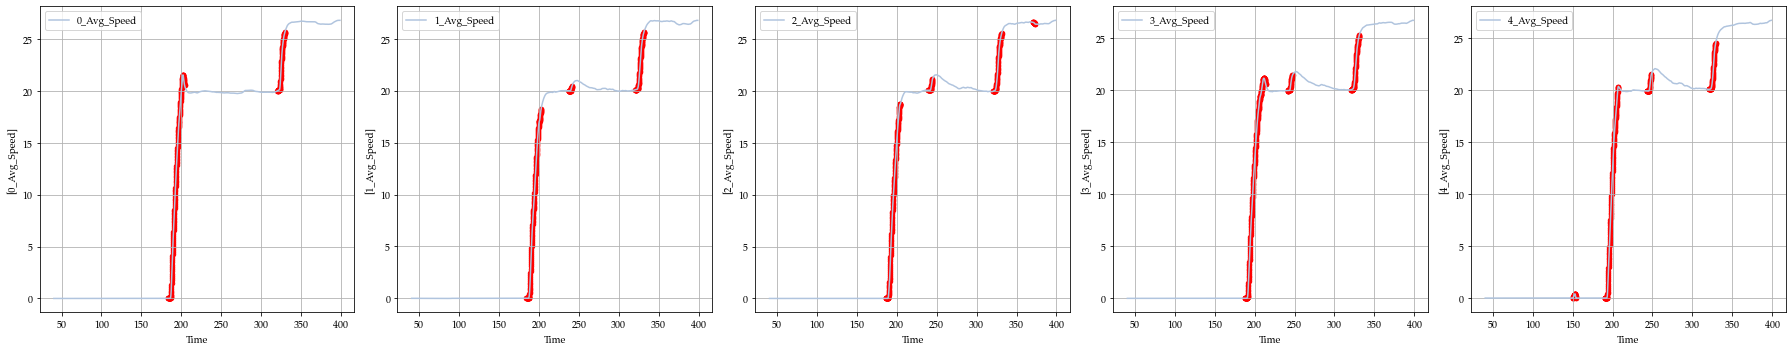

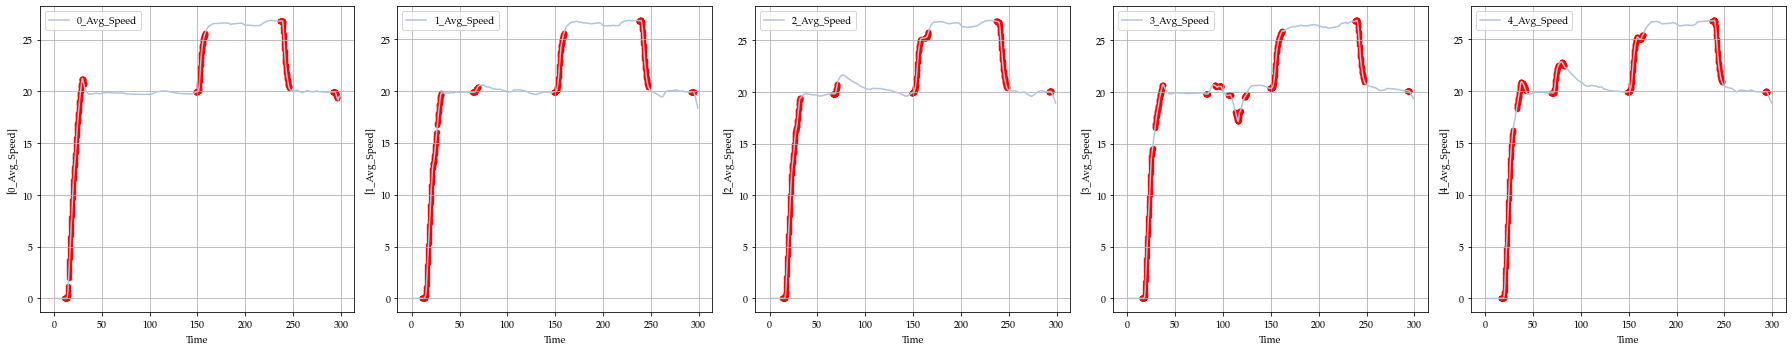

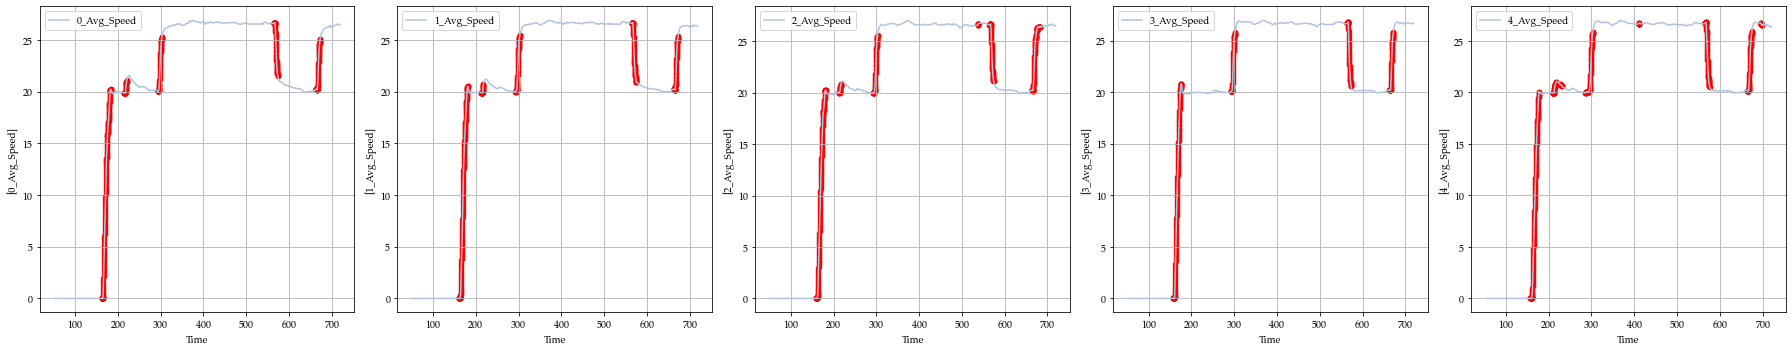

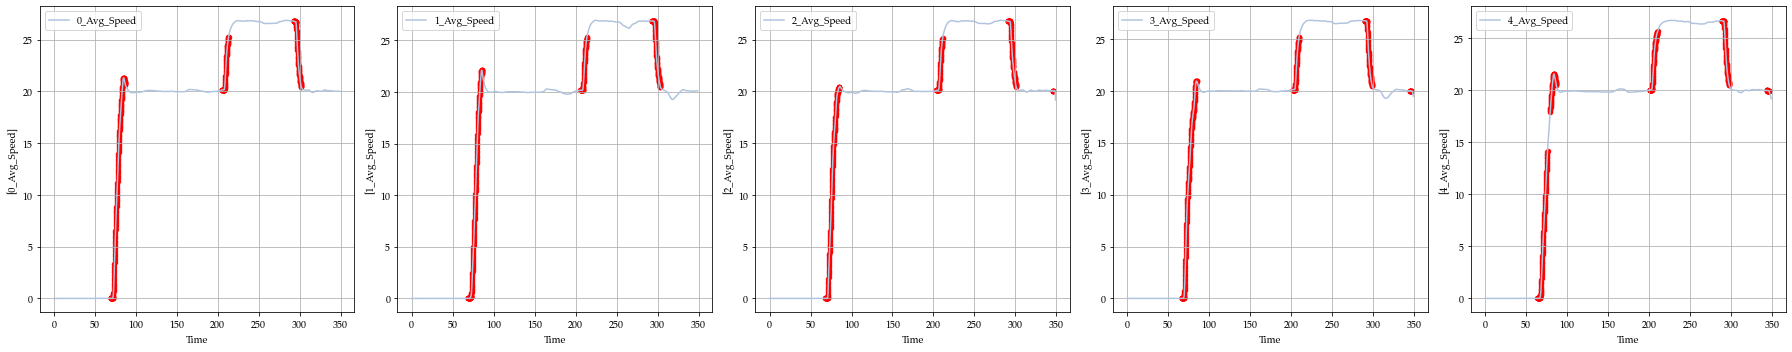

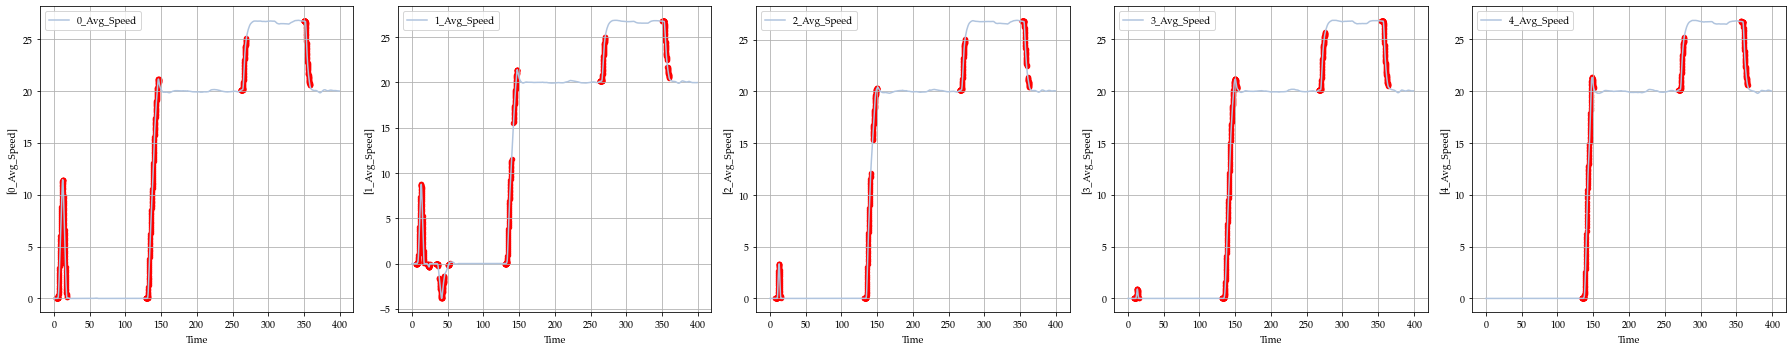

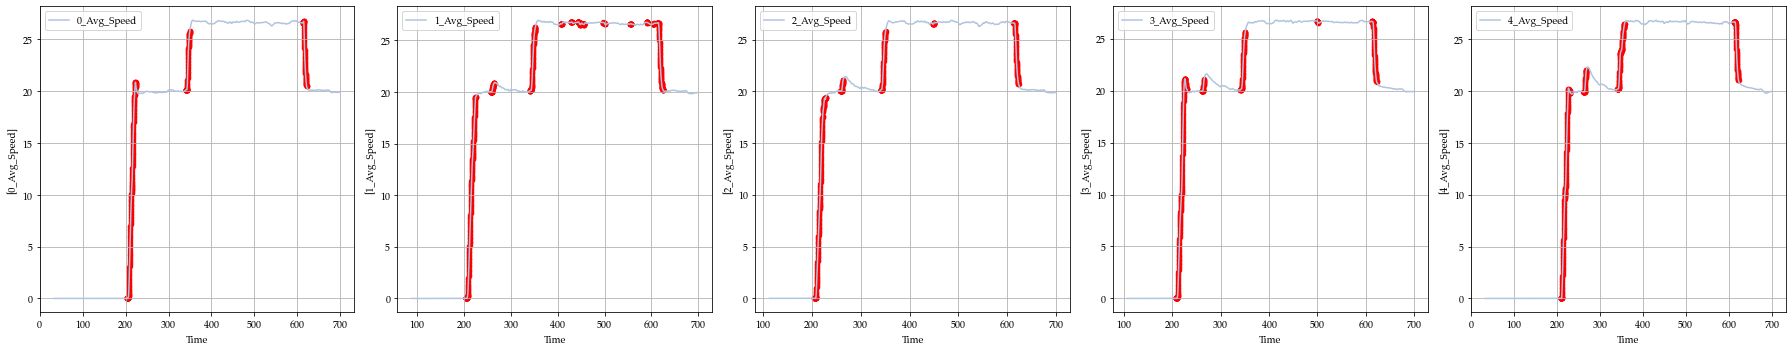

In [5]:
[l.plot_speeds_changes() for l in lData];


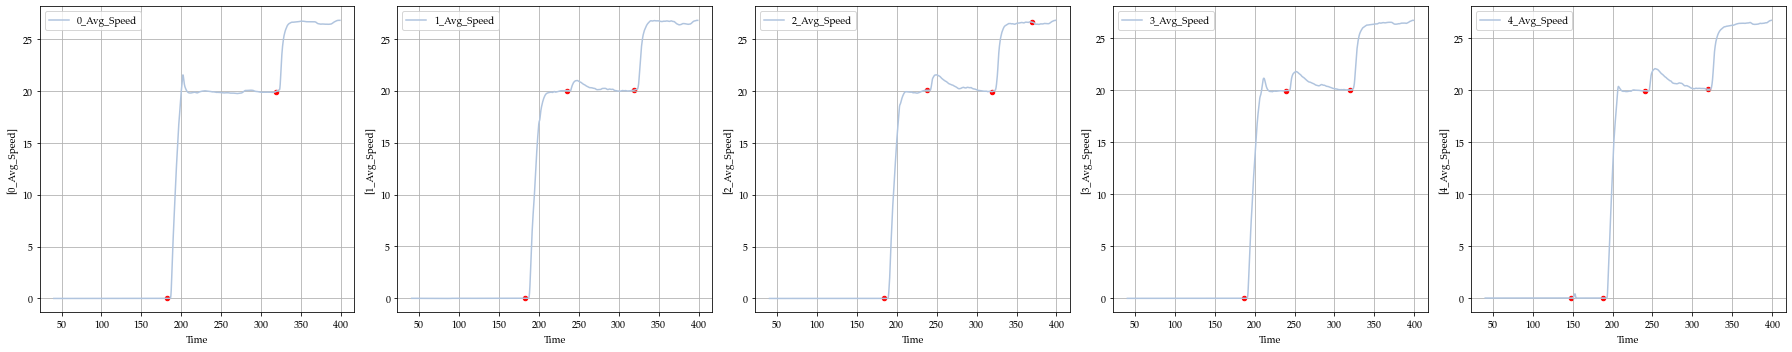

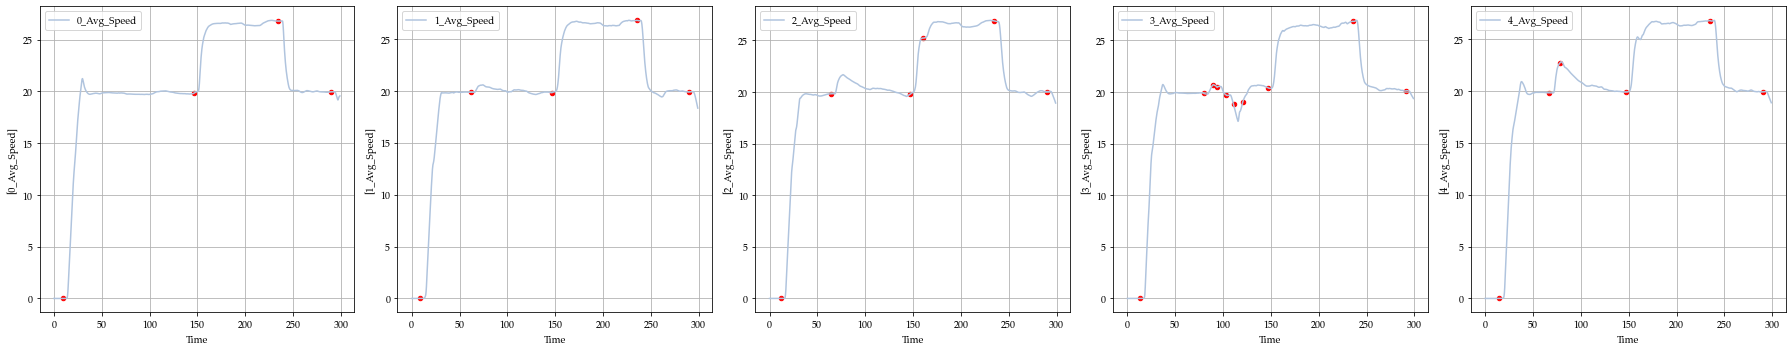

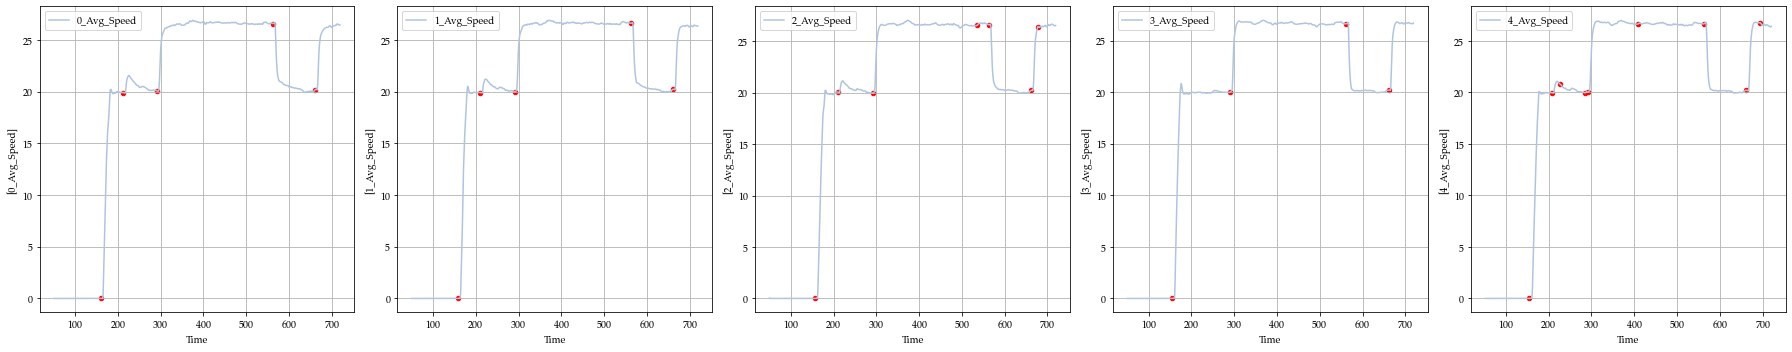

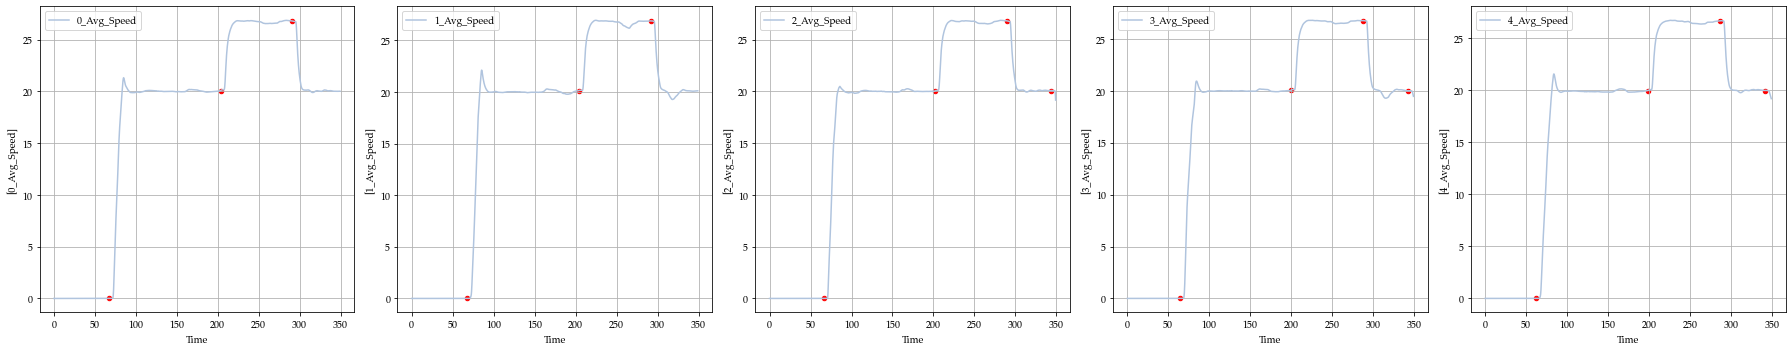

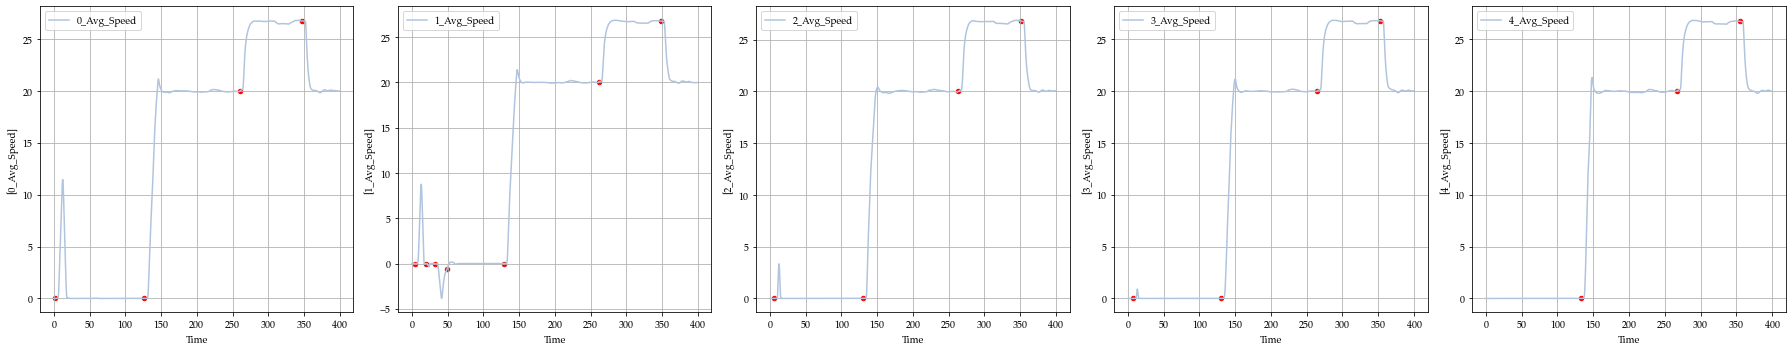

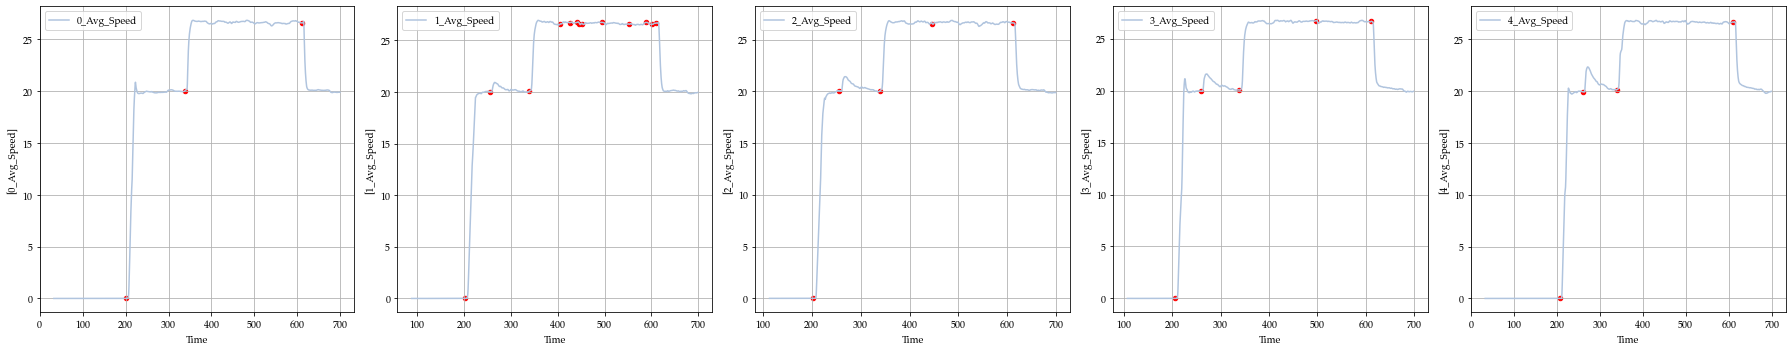

In [6]:
[l.plot_speed_timedetections() for l in lData];


### Detections

Detections are stored within the `_timedetections` property

In [7]:
lData[0]._transitiontimes


,vehid,value
0,0,181.9
1,0,318.8
18,1,182.3
19,1,235.1
20,1,318.9
37,2,184.4
38,2,237.5
39,2,319.0
40,2,368.9
57,3,186.0


### Drivers' response time 

The objective now is to compute from this detection times the reaction time, defined as the time difference between the detection time of the leader and the corresponding follower. In order to compute the time we find the difference between a specific time detection of the leader and all time detections in the followers. 

First we set the valid samples in reaction time instants 

In [8]:
total_reaction_instants = [l._compute_reaction_timeinstants() for l in lData]
total_reaction_instants[1]


[[9.2, 9.2, 11.5, 13.0, 14.5]]

In [9]:
total_response_lead = [l._compute_leader_follower_times() for l in lData]
total_response_lead[1]


,1,2,3,4
0,0.0,NaN,NaN,NaN
1,NaN,2.3,NaN,NaN
2,NaN,NaN,1.5,NaN
3,NaN,NaN,NaN,1.5


In [10]:
total_response_head = [l._compute_head_follower_times() for l in lData]
total_response_head[1]


,1,2,3,4
0,0.0,NaN,NaN,NaN
1,NaN,2.3,NaN,NaN
2,NaN,NaN,3.8,NaN
3,NaN,NaN,NaN,5.3


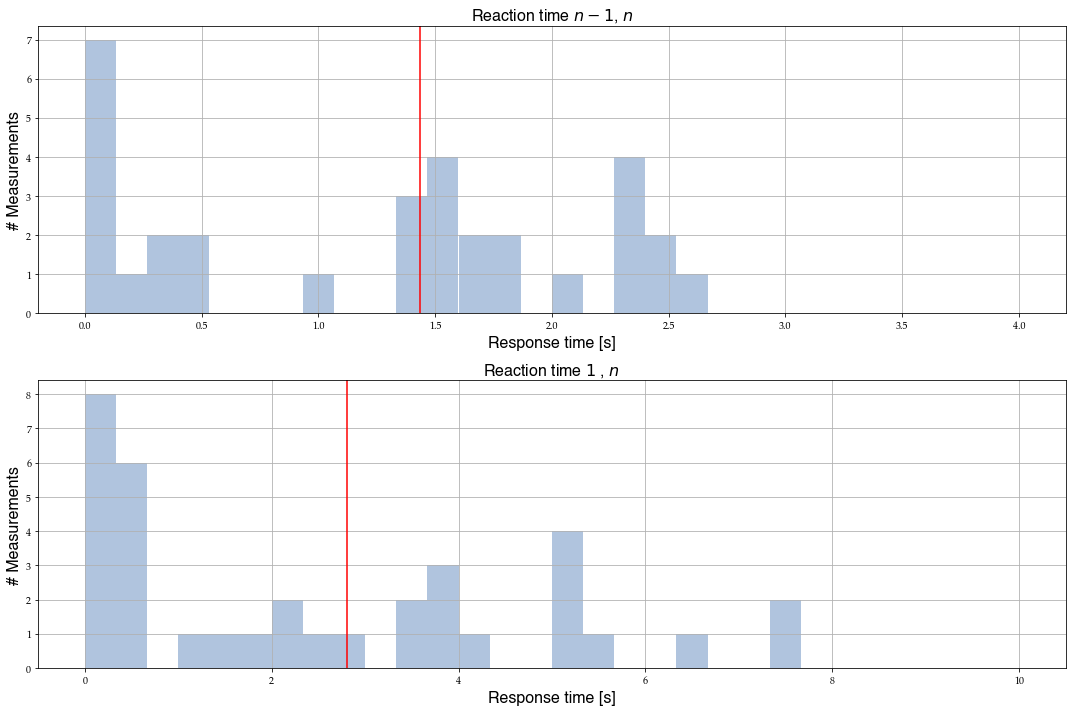

In [11]:
import pandas as pd

flatdata_resptime = pd.melt(pd.concat(total_response_lead)).dropna()
flatdata_leadtime = pd.melt(pd.concat(total_response_head)).dropna()

f, ax = plt.subplots(2,1,figsize = (15,10))

hfont = {'fontname':'Helvetica','fontsize':16}

ax[0].hist(flatdata_resptime.value,bins = 30,color='lightsteelblue', range = (0,4));
ax[0].grid(True)
y_lim = ax[0].get_ylim()
meanval = np.mean(flatdata_resptime.value)
ax[0].axvline(meanval,*y_lim,color='r')
ax[0].set_xlabel('Response time [s]',**hfont);
ax[0].set_ylabel('# Measurements',**hfont);
ax[0].set_title('Reaction time $n-1$, $n$',**hfont);

ax[1].hist(flatdata_leadtime.value,bins = 30,color='lightsteelblue',range=(0,10));
ax[1].grid(True)
y_lim = ax[1].get_ylim()
meanval = np.mean(flatdata_leadtime.value)
ax[1].axvline(meanval,*y_lim,color='r')
ax[1].set_xlabel('Response time [s]',**hfont);
ax[1].set_ylabel('# Measurements',**hfont);
ax[1].set_title('Reaction time $1$ , $n$',**hfont);
plt.tight_layout()

# # plt.savefig("data/media/Fig4ResponseTimeHistograms.png")


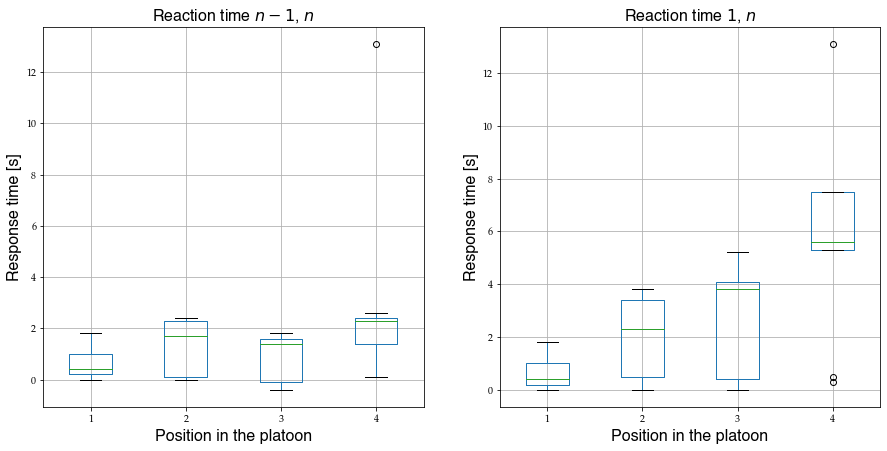

In [12]:
f, ax = plt.subplots(1,2,figsize = (15,7))


# dflead_time = pd.DataFrame(total_resp_lead, columns = [1,2,3,4])
# dflead_time[dflead_time>10] = np.nan
dflead_time = pd.concat(total_response_lead)
dflead_time.boxplot(ax=ax[0]);
ax[1].set_ylabel('Response time [s]',**hfont);
ax[1].set_xlabel('Position in the platoon',**hfont);
ax[1].set_title('Reaction time $1$, $n$',**hfont);


# dfresp_time = pd.DataFrame(total_resp_time, columns = [1,2,3,4])
# dfresp_time[dfresp_time>10] = np.nan
dfresp_time = pd.concat(total_response_head)
dfresp_time.boxplot(ax= ax[1]);
ax[0].set_ylabel('Response time [s]',**hfont);
ax[0].set_xlabel('Position in the platoon',**hfont);
ax[0].set_title('Reaction time $n-1$, $n$',**hfont);

# plt.savefig("data/media/Fig5ResponseTimePosition.png")


## Analysis from Stat data

Here results of both databases are analyzed and combined:

In [21]:
stat_kernel_CARMA = pd.read_csv('data/processed/stat_kernel_CARMA.csv')
stat_kernel_proof = pd.read_csv('data/processed/stat_kernel_proof.csv')
stat_kernel = pd.concat([stat_kernel_CARMA, stat_kernel_proof])
stat_kernel.head()

,id,veh_position,reaction_time,time,veh_mode
0,5_1,1.0,0.6,185.7,1.0
1,5_1,1.0,0.4,322.4,1.0
2,5_2,2.0,2.8,187.9,1.0
3,5_2,2.0,0.4,322.4,1.0
4,5_3,3.0,4.2,189.3,1.0


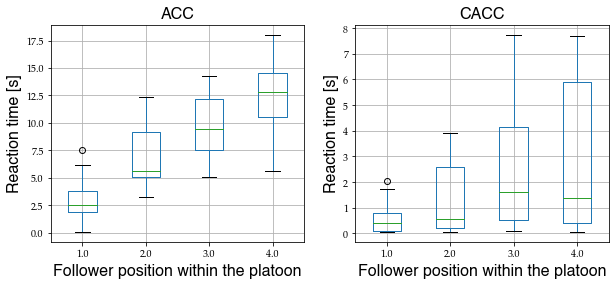

In [22]:
f,a = plt.subplots(1,2,figsize = (10,4))
titles = ['ACC','CACC']

for group, title, a in zip(stat_kernel.groupby('veh_mode'),titles, a.flatten()):
    mode ,data = group
    dfg = data[['veh_position','reaction_time']].reset_index().pivot(columns='veh_position',values='reaction_time')
    dfg.boxplot(ax=a)
    a.set_xlabel('Follower position within the platoon',**hfont)
    a.set_ylabel('Reaction time [s]',**hfont);
    a.set_title(title,**hfont)
    a.set_xticks([1,2,3,4]);

# Comment avoid saving the plot
# plt.savefig("data/media/Fig1ResponseTimeFollower.pdf");

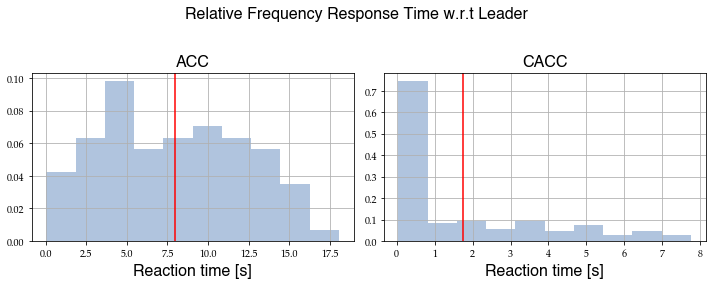

In [23]:
f,ax = plt.subplots(1,2,figsize=(10,4))
titles = ['ACC','CACC']

f.suptitle('Relative Frequency Response Time w.r.t Leader\n',**hfont)

for d,a,title in zip(stat_kernel.groupby('veh_mode'),ax.flatten(),titles):
    key,val = d
    val.reaction_time.hist(density=True,ax=a,color= 'lightsteelblue')
    y_lim = (0,1)
    meanval = val.reaction_time.mean()
    a.axvline(meanval,*y_lim,color='r')
    a.set_xlabel('Reaction time [s]',**hfont)
    a.set_title(title,**hfont)

plt.tight_layout()
# plt.savefig("data/media/Fig2ResponseTimeHistogram.pdf"); 

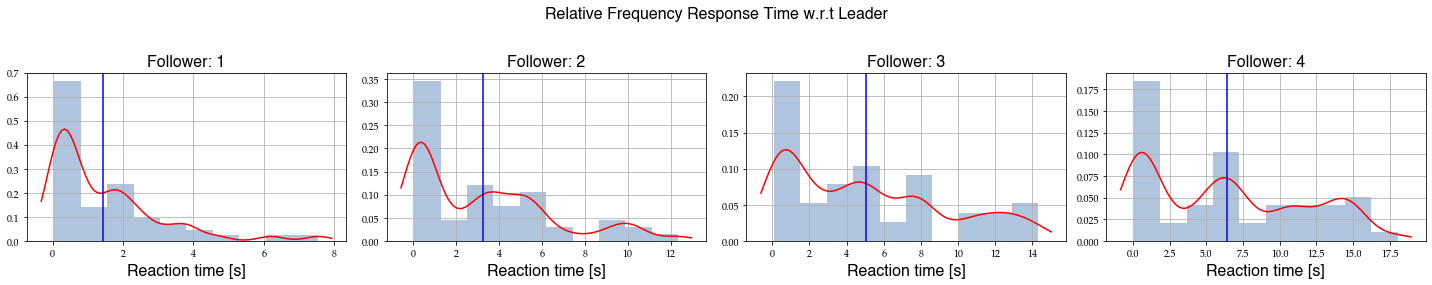

In [24]:
NFOLLOWER = len(stat_kernel['veh_position'].unique())
HWEIGHTS = [0.15, 0.3, 0.6, 0.7]

from scipy import stats 
import numpy as np
NFOLLOWER = len(stat_kernel['veh_position'].unique())
f, ax = plt.subplots(1, NFOLLOWER,figsize = (20,4))

f.suptitle('Relative Frequency Response Time w.r.t Leader\n',**hfont)
for df, a, h in zip(stat_kernel.groupby('veh_position'), ax.flatten(), HWEIGHTS):
    follower, data = df
    data['reaction_time'].hist(ax=a,density=True,color= 'lightsteelblue')
    kernel = stats.gaussian_kde(data['reaction_time'], bw_method='silverman')
    kernel.set_bandwidth(bw_method=kernel.factor/2)
    # Check this for info on bandwith setting
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.set_bandwidth.html
    xlims = np.linspace(*a.get_xlim(),100)
    a.plot(xlims,kernel(xlims), color='r')
    a.set_xlabel('Reaction time [s]',**hfont)
    a.set_title(f'Follower: {int(follower)}',**hfont)
    a.axvline(data['reaction_time'].mean(), color='b')

plt.tight_layout()
# Comment avoid saving the plot
# plt.savefig("data/media/Fig3ResponseTimeKernel.pdf")

Credits. E. Lanaud, A. Ladino, C. Buission